## Example 1: NetLogo interaction through the pyNetLogo connector

This notebook provides a simple example of interaction between a NetLogo model and the Python environment, using the Wolf Sheep Predation model included in the NetLogo example library (Wilensky, 1999).

We start by instantiating a link to NetLogo, loading the model, and executing the `setup` command in NetLogo.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jpype
import pyNetLogo


netlogo = pyNetLogo.NetLogoLink(gui=True)

netlogo.load_model(r'Wolf Sheep Predation_v6.nlogo')
netlogo.command('setup')

We can use the `write_NetLogo_attriblist` function to pass properties to agents from a Pandas dataframe -- for instance, initial values for given attributes. This function improves performance by simultaneously setting multiple properties for multiple agents in a single function call.

As an example, we first load data from an Excel file into a dataframe. Each row corresponds to an agent, with columns for each attribute (including the `who` NetLogo identifier, which is required by the function). In this case, we set coordinates for the agents using the `xcor` and `ycor` attributes.

In [2]:
agent_xy = pd.read_excel('xy_DataFrame.xlsx')
agent_xy[['who','xcor','ycor']].head(5)

,who,xcor,ycor
0,0,-24.000000,-24.000000
1,1,-23.666667,-23.666667
2,2,-23.333333,-23.333333
3,3,-23.000000,-23.000000
4,4,-22.666667,-22.666667


We can then pass the dataframe to NetLogo, specifying which attributes and which agent type we want to update:

In [3]:
netlogo.write_NetLogo_attriblist(agent_xy[['who','xcor','ycor']], 'a-sheep')

We can check the data exchange by returning data from NetLogo to the Python workspace, using the report function. In the example below, the function returns arrays for the `xcor` and `ycor` coordinates of the `sheep` agents, sorted by their `who` number. These are then plotted on a conventional scatter plot.

The `report` function directly passes a string to the NetLogo instance, so that the command syntax may need to be adjusted depending on the NetLogo version. The `netlogo_version` property of the link object can be used to check the current version.

In [4]:
if netlogo.netlogo_version == '6':
    x = netlogo.report('map [s -> [xcor] of s] sort sheep')
    y = netlogo.report('map [s -> [ycor] of s] sort sheep')
elif netlogo.netlogo_version == '5':
    x = netlogo.report('map [[xcor] of ?1] sort sheep')
    y = netlogo.report('map [[ycor] of ?1] sort sheep')

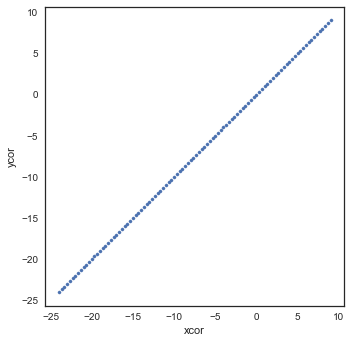

In [5]:
sns.set_style('white')

fig, ax = plt.subplots(1)

ax.scatter(x, y, s=10)
ax.set_xlabel('xcor')
ax.set_ylabel('ycor')
ax.set_aspect('equal')

plt.show()

We can then run the model for 100 ticks and update the Python coordinate arrays for the sheep agents, and return an additional array for each agent's energy value. The latter is plotted on a histogram for each agent type.

In [6]:
#We can use either of the following commands to run for 100 ticks:

netlogo.command('repeat 100 [go]')
#netlogo.repeat_command('go', 100)

if netlogo.netlogo_version == '6':
    x = netlogo.report('map [[?1] -> [xcor] of ?1] sort sheep')
    y = netlogo.report('map [[?1] -> [ycor] of ?1] sort sheep')
    energy_sheep = netlogo.report('map [[?1] -> [energy] of ?1] sort sheep')
elif netlogo.netlogo_version == '5':
    x = netlogo.report('map [[xcor] of ?1] sort sheep')
    y = netlogo.report('map [[ycor] of ?1] sort sheep')
    energy_sheep = netlogo.report('map [[energy] of ?1] sort sheep')
     
energy_wolves = netlogo.report('[energy] of wolves') #NetLogo returns these in random order

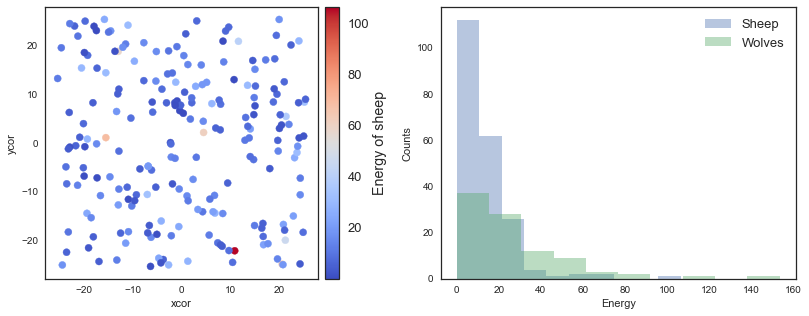

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2)
sns.set_context('talk')
sc = ax[0].scatter(x, y, s=50, c=energy_sheep, cmap=plt.cm.coolwarm)
ax[0].set_xlabel('xcor')
ax[0].set_ylabel('ycor')
ax[0].set_aspect('equal')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(sc, cax=cax, orientation='vertical')
cbar.set_label('Energy of sheep')

sns.distplot(energy_sheep, kde=False, bins=10, ax=ax[1], label='Sheep')
sns.distplot(energy_wolves, kde=False, bins=10, ax=ax[1], label='Wolves')
ax[1].set_xlabel('Energy')
ax[1].set_ylabel('Counts')
ax[1].legend()

fig.set_size_inches(14,5)

#plt.savefig('JASSS figures/Demo - Basic reporters.pdf', bbox_inches='tight')
#plt.savefig('JASSS figures/Demo - Basic reporters.png', dpi=300, bbox_inches='tight')
plt.show()

The `repeat_report` function returns a Pandas dataframe containing reported values over a given number of ticks, for one or multiple reporters. The dataframe is indexed by ticks, with labeled columns for each reporter. In this case, we track the number of wolf and sheep agents over 200 ticks; the outcomes are first plotted as a function of time. The number of wolf agents is then plotted as a function of the number of sheep agents, to approximate a phase-space plot. 

In [8]:
counts = netlogo.repeat_report(['count wolves','count sheep'], 200)

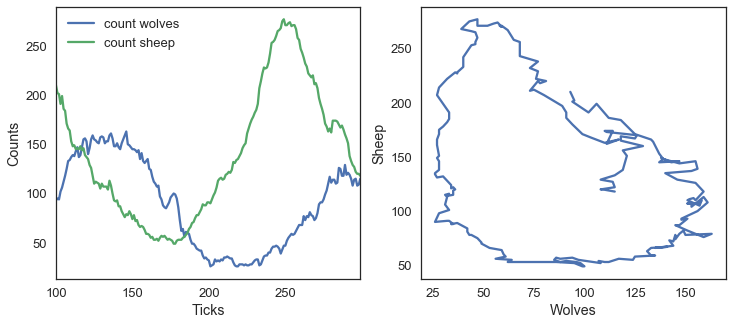

In [9]:
fig, ax = plt.subplots(1, 2)
sns.set_context('talk')
counts.plot(x=counts.index, ax=ax[0])
ax[0].set_xlabel('Ticks')
ax[0].set_ylabel('Counts')
ax[1].plot(counts['count wolves'], counts['count sheep'])
ax[1].set_xlabel('Wolves')
ax[1].set_ylabel('Sheep')

fig.set_size_inches(12,5)
#plt.savefig('JASSS figures/Demo - repeat_report.pdf', bbox_inches='tight')
#plt.savefig('JASSS figures/Demo - repeat_report.png', dpi=300, bbox_inches='tight')
plt.show()

The `repeat_report` function can also be used with reporters that return an array. In this case, we track the energy of the wolf and sheep agents over 5 ticks, and plot the distribution of the wolves' energy at the final tick recorded in the dataframe.

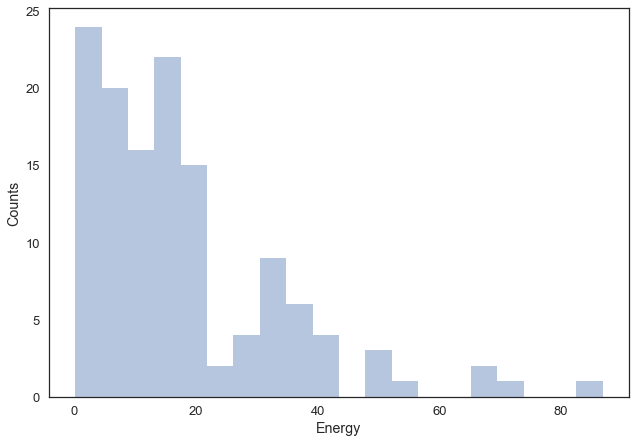

In [10]:
energy_df = netlogo.repeat_report(['[energy] of wolves', '[energy] of sheep'], 5)

fig, ax = plt.subplots(1)

sns.distplot(energy_df['[energy] of wolves'].iloc[-1], kde=False, bins=20, ax=ax)
ax.set_xlabel('Energy')
ax.set_ylabel('Counts')

plt.show()

Finally, the `patch_report` function is used to return a dataframe which (for this example) contains the `countdown` attribute of each NetLogo patch. This dataframe essentially replicates the NetLogo environment, with column labels corresponding to the xcor patch coordinates, and indices following the pycor coordinates.

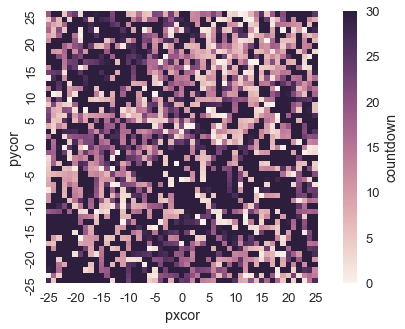

In [11]:
countdown_df = netlogo.patch_report('countdown')

fig, ax = plt.subplots(1)

patches = sns.heatmap(countdown_df, xticklabels=5, yticklabels=5, cbar_kws={'label':'countdown'}, ax=ax)
ax.set_xlabel('pxcor')
ax.set_ylabel('pycor')
ax.set_aspect('equal')
fig.set_size_inches(9,5)

#plt.savefig('JASSS figures/Demo - Patches.pdf', bbox_inches='tight')
#plt.savefig('JASSS figures/Demo - Patches.png', dpi=300, bbox_inches='tight')
plt.show()

The dataframes can be manipulated with any of the existing Pandas functions, for instance by exporting to an Excel file. The `patch_set` function provides the inverse functionality to `patch_report`, and updates the NetLogo environment from a dataframe.

In [12]:
countdown_df.to_excel('countdown.xlsx')
netlogo.patch_set('countdown', countdown_df.max()-countdown_df)

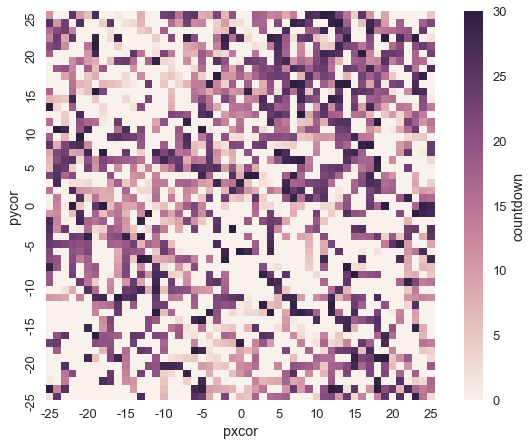

In [13]:
countdown_update_df = netlogo.patch_report('countdown')

fig, ax = plt.subplots(1)

patches = sns.heatmap(countdown_update_df, xticklabels=5, yticklabels=5, cbar_kws={'label':'countdown'}, ax=ax)
ax.set_xlabel('pxcor')
ax.set_ylabel('pycor')
ax.set_aspect('equal')

plt.show()

Finally, the `kill_workspace()` method shuts down the NetLogo instance.

In [14]:
netlogo.kill_workspace()